# Project

### Goal: Improve our original estimate of the log error by using clustering methodologies.

## Acquisition, Prep, and Initial Exploration

Using the notebook and files you created during the exercises make any changes, additions, etc. you want at this point. NOTE: You will NOT be splitting into train and test at this point.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None, 'display.max_rows', None)

import acquire
import wrangle_zillow
import wrangle_zillow_r

In [2]:
# zillow = acquire.get_zillow(acquire.sql)
# Save file to csv so I can quit asking the server for this data
# zillow.to_csv('zillow.csv')

In [3]:
zillow = pd.read_csv('zillow.csv', index_col='id')
# drop extra column that comes in from csv files
# zillow = zillow.drop(columns='Unnamed: 0')

In [4]:
orig_rows = zillow.shape[0]
orig_cols = zillow.shape[1]
print (f'There are {orig_rows} rows and {orig_cols} columns in the starting dataframe.')

There are 77575 rows and 67 columns in the starting dataframe.


In [5]:
# Test wrangle_zillow function

In [6]:
zillow = wrangle_zillow.wrangle_zillow()

In [7]:
zillow.to_csv('zillow_reduced.csv')

In [8]:
new_rows = zillow.shape[0]
new_cols = zillow.shape[1]
print (f'There are {orig_rows} rows and {orig_cols} columns in the starting dataframe.')
print (f'There are {new_rows} rows and {new_cols} columns in the modified dataframe.')

There are 77575 rows and 67 columns in the starting dataframe.
There are 64793 rows and 36 columns in the modified dataframe.


## Exploration with Clustering

### Cluster the Target Variable

Perform clustering with logerror as the only feature used in the clustering algorithm. Decide on a number of clusters to use, and store the cluster predictions back onto your data frame as cluster_target. Look at the centroids that were produced in this process. What do they tell you?

Use the produced clusters to help you explore through visualization how logerror relates to other variables. (A common way to do this is to use color to indicate the cluster id, and the other variables can be your x-axis and y-axis. (hint: look at your swarmplot function)).

### Cluster Independent Variables

You should also perform some clustering based on a number of independent variables. Create and evaluate several clustering models based on subsets of the independent variables. Here are some ideas:

- Location, that is, latitude and longitude
- Size (finished square feet)
- Location and size

Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

### Test the Significance of Clusters
Use statistical testing methods to determine whether the clusters you have created are significant in terms of their relationship to logerror.

## Modeling

### Feature Engineering

Remove variables that are not needed, wanted, useful, or are redundant.

In [9]:
# Do this after generating new features

Add any features you think may be useful.

In [10]:
# Age = yearbuilt - 2017
zillow['age'] = (2017 - zillow.yearbuilt).astype('int')

# Tax Rate = taxamount / value
zillow['tax_rate'] = (zillow.taxamount / zillow.taxvaluedollarcnt).astype('float').round(4)

# $/sqft
zillow['cost_land_sf'] = (zillow.landtaxvaluedollarcnt / (zillow.lotsizesquarefeet + 0.0001)).astype('float').round(4)
zillow['cost_structure_sf'] = (zillow.structuretaxvaluedollarcnt / zillow.finishedsquarefeet12).astype('float').round(4)

# Has features
zillow['has_ac'] = np.where(zillow.airconditioningtypeid > 0, 1, 0)
zillow['has_heating'] = np.where(zillow.heatingorsystemtypeid == 13, 0, 1)
zillow['has_fire'] = np.where(zillow.fireplacecnt > 0, 1, 0)
zillow['has_garage'] = np.where(zillow.garagecarcnt > 0, 1, 0)
zillow['has_deck'] = np.where(zillow.decktypeid > 0, 1, 0)

# How many features
zillow['is_extra'] = (zillow.airconditioningtypeid +
                      zillow.has_deck +
                      zillow.has_fire +
                      zillow.has_garage +
                      zillow.hashottuborspa +
                      zillow.has_heating +
                      zillow.poolcnt)

# one hot encode counties
zillow['LA'] = np.where(zillow.county == 'Los_Angeles', 1, 0)
zillow['OC'] = np.where(zillow.county == 'Orange', 1, 0)
zillow['VC'] = np.where(zillow.county == 'Ventura', 1, 0)

In [11]:
# drop redundant columns, 
# and found out no one has a basement
zillow = zillow.drop(columns=['yearbuilt', 'airconditioningtypeid', 
                              'heatingorsystemtypeid', 'basementsqft',
                              'fireplacecnt', 'decktypeid', 'unitcnt',
                              'propertycountylandusecode'])

In [12]:
# Plots to see how these features are reflected in the df

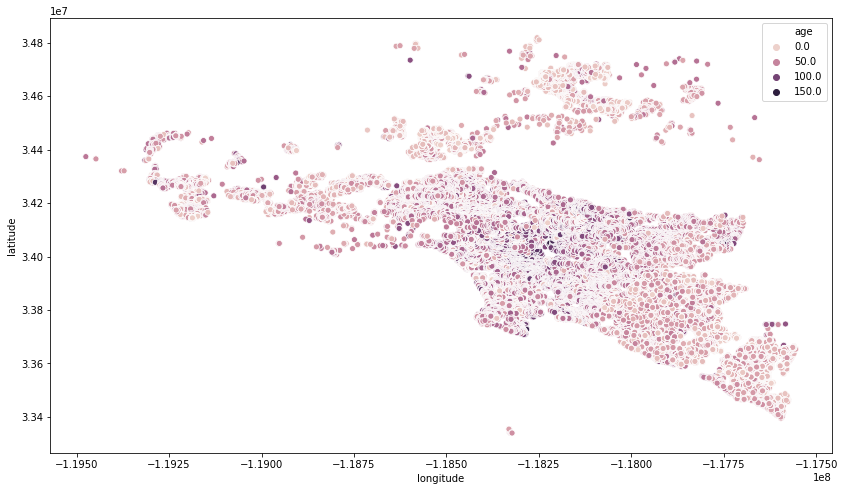

In [13]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.age).astype('float'), data=zillow)

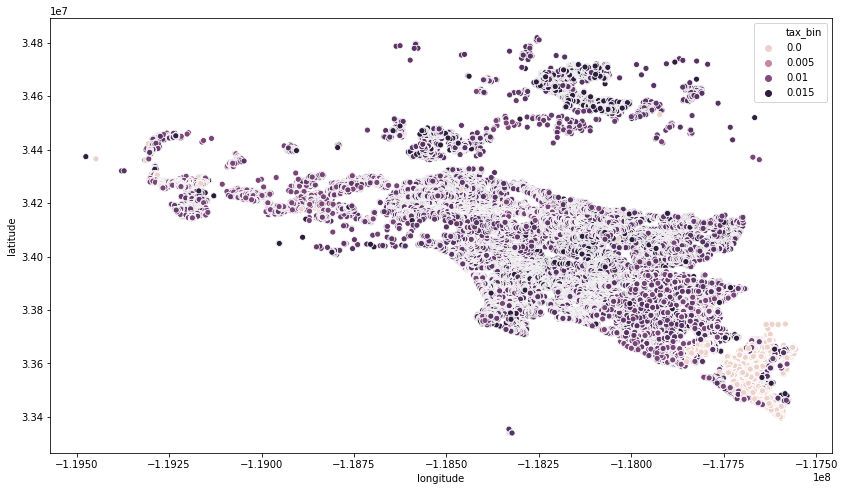

In [37]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.tax_bin).astype('float'), data=zillow)

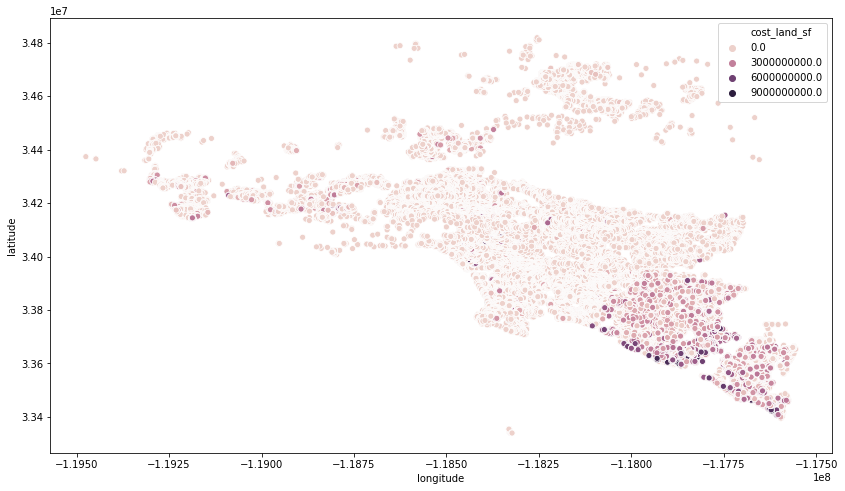

In [15]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.cost_land_sf).astype('float'), data=zillow)

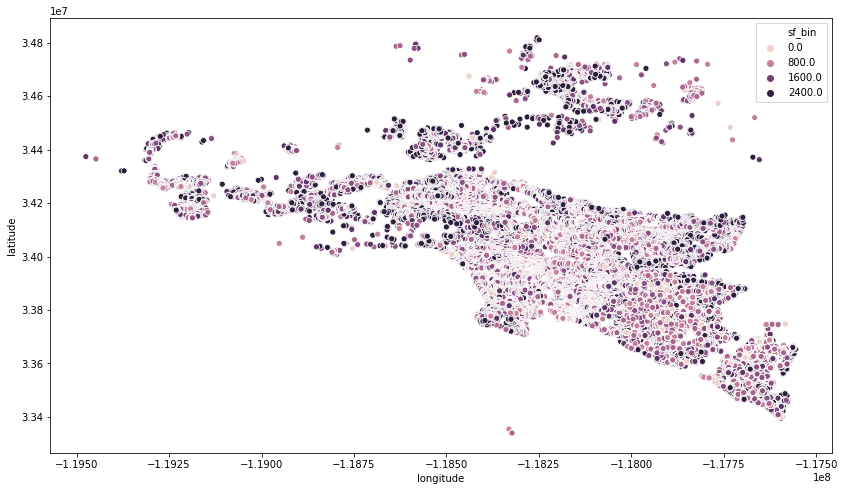

In [38]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.sf_bin).astype('float'), data=zillow)

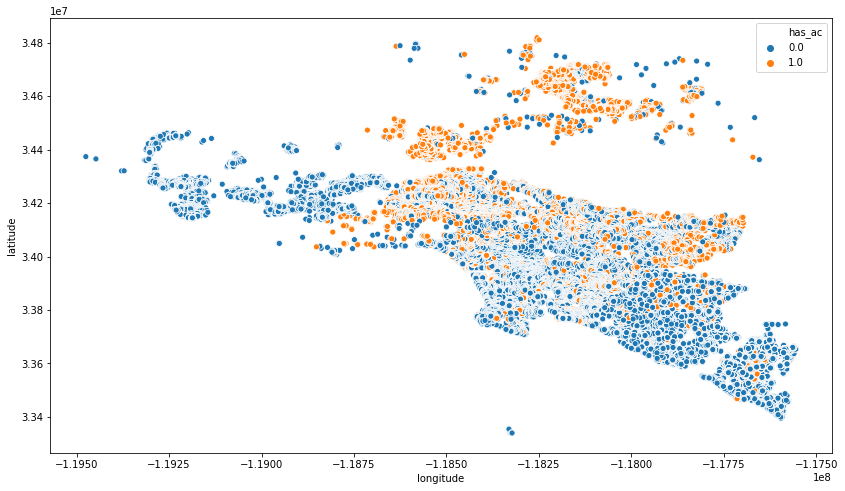

In [17]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_ac).astype('float'), data=zillow)

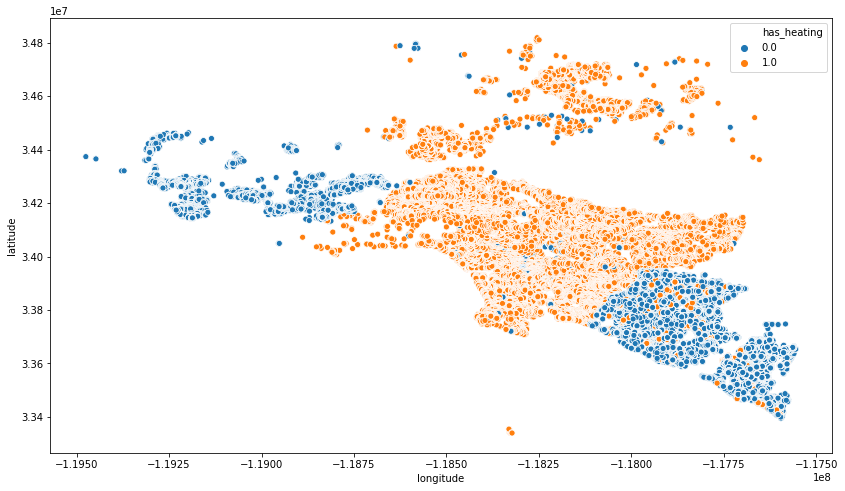

In [18]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_heating).astype('float'), data=zillow)

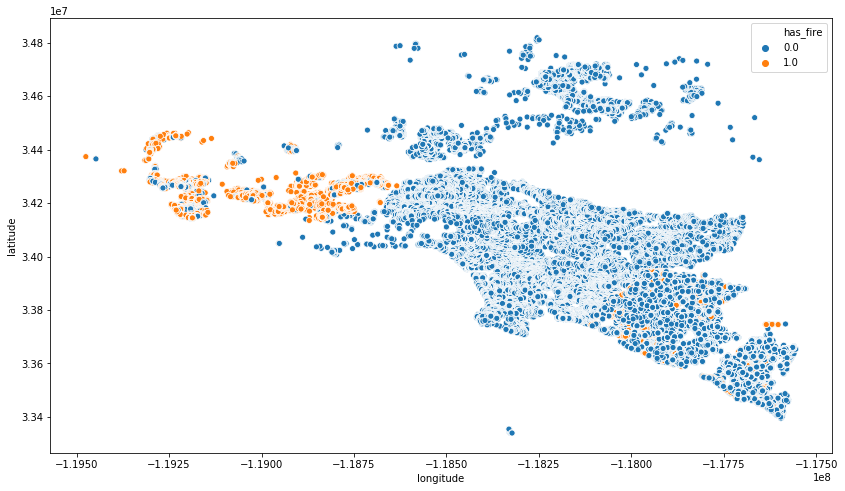

In [19]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_fire).astype('float'), data=zillow)

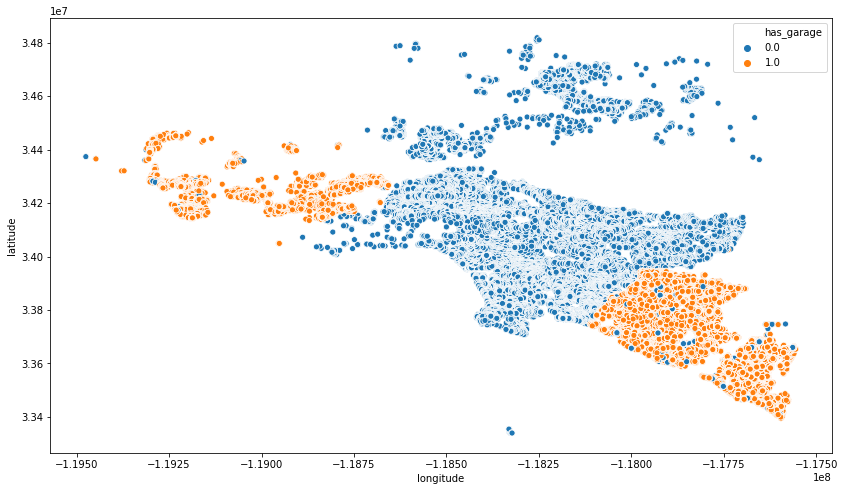

In [20]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_garage).astype('float'), data=zillow)

# Bin features

(array([  189.,  5924., 17686., 17429., 10654.,  5969.,  3577.,  1939.,
         1018.,   408.]),
 array([ 152.,  525.,  898., 1271., 1644., 2017., 2390., 2763., 3136.,
        3509., 3882.]),
 <a list of 10 Patch objects>)

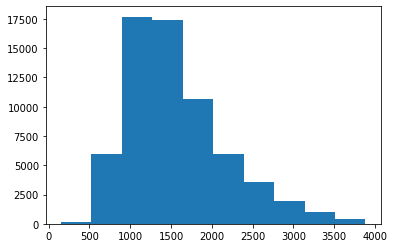

In [21]:
plt.hist(zillow.finishedsquarefeet12)

In [22]:
zillow['sf_bin'] = pd.cut(zillow.finishedsquarefeet12, 
                              bins = [0, 800, 1100, 1400, 1800, 2200, 10000],
                              labels = [0, 800, 1100, 1400, 1800, 2200])

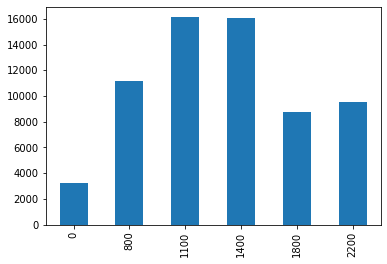

In [23]:
zillow.sf_bin.value_counts(sort = False).plot.bar()

(array([58589.,  2439.,  1165.,   773.,   539.,   510.,   300.,   213.,
          158.,   107.]),
 array([     0. ,  39006.2,  78012.4, 117018.6, 156024.8, 195031. ,
        234037.2, 273043.4, 312049.6, 351055.8, 390062. ]),
 <a list of 10 Patch objects>)

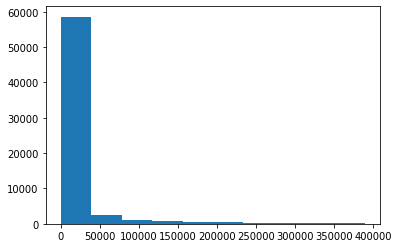

In [24]:
plt.hist(zillow.lotsizesquarefeet)

In [25]:
zillow['lotsf_bin'] = pd.cut(zillow.lotsizesquarefeet, 
                              bins = [0, 4000, 6000, 8000, 20000, 40000, 100000],
                              labels = [0, 4000, 6000, 8000, 20000, 40000])

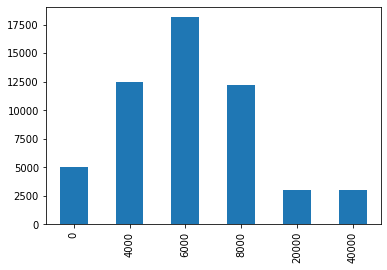

In [26]:
zillow.lotsf_bin.value_counts(sort = False).plot.bar()

(array([ 4631.,  8215., 13666., 13330., 15480.,  4481.,  3761.,  1059.,
          153.,    17.]),
 array([  1. ,  14.8,  28.6,  42.4,  56.2,  70. ,  83.8,  97.6, 111.4,
        125.2, 139. ]),
 <a list of 10 Patch objects>)

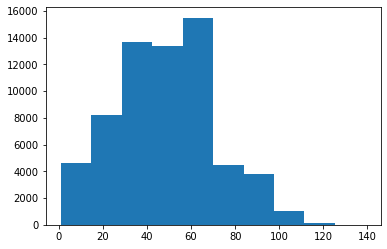

In [27]:
plt.hist(zillow.age)

In [28]:
zillow['age_bin'] = pd.cut(zillow.age, 
                              bins = [0, 15, 30, 45, 60, 70, 120],
                              labels = [0, 15, 30, 45, 60, 70])

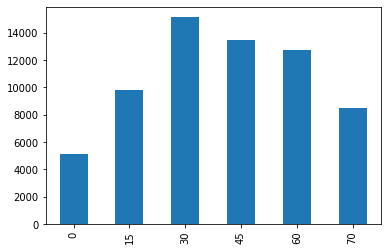

In [29]:
zillow.age_bin.value_counts(sort = False).plot.bar()

(array([6.4763e+04, 2.4000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e-04, 8.1690e-02, 1.6328e-01, 2.4487e-01, 3.2646e-01,
        4.0805e-01, 4.8964e-01, 5.7123e-01, 6.5282e-01, 7.3441e-01,
        8.1600e-01]),
 <a list of 10 Patch objects>)

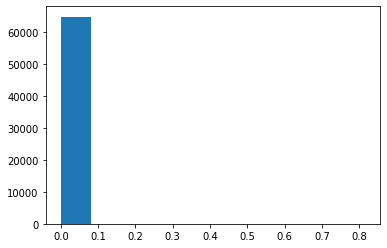

In [30]:
plt.hist(zillow.tax_rate)

In [31]:
zillow['tax_bin'] = pd.cut(zillow.tax_rate, 
                              bins = [0, 0.0105, 0.0115, 0.012, 0.0125, 0.015, 0.5],
                              labels = [0, 0.0105, 0.0115, 0.012, 0.0125, 0.015])

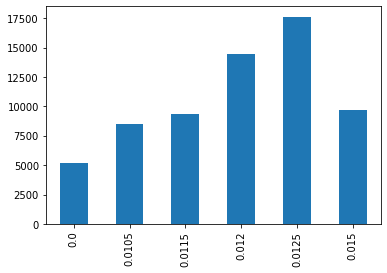

In [32]:
zillow.tax_bin.value_counts(sort = False).plot.bar()

In [33]:
# Save this file as csv
zillow.to_csv('zillow_fe.csv')

In [34]:
new_rows = zillow.shape[0]
new_cols = zillow.shape[1]
print (f'There are {new_rows} rows and {new_cols} columns in the modified dataframe.')

There are 64793 rows and 45 columns in the modified dataframe.


Split your data into training and test sets.

In [35]:
train, test = wrangle_zillow.split_my_data(zillow, 0.8)

scaler, train, test = wrangle_zillow.min_max_scaler(train, test)

train, valid = wrangle_zillow.split_my_data(train, 0.8)

Create subsets of data if you would like to create multiple models and then merge (such as, a different model for each cluster or for each county).

In [36]:
train_LA = train[train.county == 'Los_Angeles']
train_OC = train[train.county == 'Orange']
train_VC = train[train.county == 'Ventura']

valid_LA = valid[valid.county == 'Los_Angeles']
valid_OC = valid[valid.county == 'Orange']
valid_VC = valid[valid.county == 'Ventura']

test_LA = test[test.county == 'Los_Angeles']
test_OC = test[test.county == 'Orange']
test_VC = test[test.county == 'Ventura']

In [ ]:
# Reduce features by clustering

group1 = train[['building']]

X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
kmeans = KMeans(n_clusters = 5, random_state=539)
kmeans.fit(X_scaled)
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)
train['cluster'] = 'cluster_' + train.cluster.astype(str)



## Model Selection

Train at least 3 different models (a model is different if there are changes in one or more of the following: features, hyper-parameters, algorithm). Create object, fit, predict & evaluate. Use mean absolute error or mean squared error to evaluate. Also, try regression algorithms you have not used before.

Evaluate your best model on your test data set to get an idea of your model's out of sample error.